
# Prediction of the KS system: a model using a 2D Convolution Neural Network

In this notebook, I will use a model of Deep Learning to predict the KS system. More precisely, we wanna predict the next step of a given history of state of the system. To do it, a simple convolutional neural network will be used.

To generate the data, I will use the KS.py code provided by Alessandro Bucci.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd ../content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [3]:
import numpy as np
import torch as th
import time
from scipy import stats
#from KS import KS
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [4]:
def drawKS(U_sim, x_axis, t_axis ,startT=0,endT=0, width = 10, divwidth = 4): 
    """
    This function will plot the evolution of the KS system (U_sim) over time (t_axis)
    
    """
    fig = plt.figure(figsize=(width, width/divwidth))
    ax = fig.gca()
    ola = ax.contourf((t_axis[startT:endT])/20.83, x_axis, U_sim[startT:endT,:].T, 15)
    cbar = plt.colorbar(ola)
    plt.xlabel('Lyapunov Times')
    plt.ylabel('X')
    plt.show()

In [ ]:
def prediction2D(model,start_position,N_step_pred,size_conv_time,steps_to_predict,state_history_norm_th):
    """
    This function will simulate the model for a given start_position of 
    state_history_norm_th from start_position to start_position+N_step_pred
    and compares this simulation with the true value given by state_history_norm_th
    
    input:
    - model: the model that will be used to make the prediction
    - start_position: the position in the vector state_history_norm_th that will start the simulation
    - N_step_pred: number of the steps to simulate
    - state_history_norm_th: the true simulation given by KS.py. it will be used as the start point
      to initiate our model simulation and to verify the quality of this simulation
    
    
    output:
    - print: the true spatiotemporal evolution of KS system
             our simulation by the model
             the difference between them per step of the simulation
    
    state_history: all the spatialtemporal evolution of the system. shape: [number of iteractions,samples_points]
    time_counter: array of the time corresponding to each interaction
    position_x: array of samples_points points that goes from 0 to length
    """

    y_true=state_history_norm_th[start_position:start_position+N_step_pred*steps_to_predict,:].squeeze()
    sample_points=state_history_norm_th.size(1)
    current_state = th.zeros((1, 1, sample_points, size_conv_time))
    current_state[0,0,:,:] = state_history_norm_th[start_position-size_conv_time:start_position,:].T
    current_state=current_state.double().cuda()
    prediction_model = th.zeros((N_step_pred*steps_to_predict, sample_points))

    for i in range(N_step_pred):
        y=model(current_state)
        if steps_to_predict < size_conv_time:
          past=current_state[:,:,:,steps_to_predict:]
          current_state=th.zeros(1,1,sample_points,size_conv_time).double().cuda()
          current_state[:,:,:,0:(size_conv_time-steps_to_predict)]=past
          y = th.reshape(y,(sample_points, steps_to_predict))
          current_state[0,0,:,(size_conv_time-steps_to_predict):] = y
          prediction_model[(i*steps_to_predict):((i+1)*steps_to_predict),:]=y.squeeze().T
        else:
          current_state=th.zeros(1,1,sample_points,size_conv_time).double().cuda()
          y = th.reshape(y,(sample_points, steps_to_predict))
          current_state[0,0,:,:] = y[:,(steps_to_predict-size_conv_time):]
          prediction_model[(i*steps_to_predict):((i+1)*steps_to_predict),:]=y.squeeze().T

    prediction_model_np = prediction_model.detach().numpy()
    y_true_np = y_true.cpu().numpy()
    dif=np.mean(np.absolute(prediction_model_np-y_true_np),axis=1)


    print('The true solution:')
    drawKS(y_true_np, position_x, time_counter,startT=1,endT=N_step_pred*steps_to_predict, width = 10, divwidth = 4) 
    print('The model solution:')
    drawKS(prediction_model_np, position_x, time_counter ,startT=1,endT=N_step_pred*steps_to_predict, width = 10, divwidth = 4)
    print('The difference between them:')
    drawKS(np.absolute(y_true_np-prediction_model_np), position_x,time_counter,startT=1,endT=N_step_pred*steps_to_predict, width = 10, divwidth = 4)

    plt.figure(figsize = (8, 3))
    plt.plot(np.arange(N_step_pred*steps_to_predict)*0.25/20.83, np.absolute(dif))
    plt.title('Difference between prediction and true value')
    plt.ylabel('MAE')
    plt.xlabel('Lyapunov Times')
    return y_true_np, prediction_model_np

## Loading and normalizing the data
First, let's set the parameters of the simulation. Pay attention to set the correct parameters to the data set loaded.

In [6]:
final_time = 2500 # the total time of the simulation
dt = 0.25 # the time step 
length = 22 # the "physical" length of the domaine. pay attention cuz this value will determine if the system is regular or chaotic
sample_points = 64 # the number of sample points on this length. It will be the size of the input in our system

In [7]:
#to load data

from numpy import load

number_of_sets = 50

state_history = np.loadtxt('state_history_5_trainingtotal.dat')
time_counter = np.linspace(0,2000*number_of_sets,8001*number_of_sets)
position_x = np.loadtxt('position_5_0.dat')

Let's normalize the data to be between [-0.975,0.975]. It will allow us to use other activation fonction (like Tanh):

In [8]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))
state_history_norm = min_max_scaler.fit_transform(state_history)

## Separating the data into training and test sets

In [ ]:
#state_history_norm=state_history_norm[:100000,:]
state_history_norm.shape

(100000, 64)

In [9]:
to_ignore = 1

size_conv_time= 10
steps_to_predict = 15

X = state_history_norm[:-size_conv_time,:] #our input: all the data excluding the last size_conv_time data
Y = state_history_norm[size_conv_time:,:] #our output: all the data minus the first size_conv_time one

NN = state_history_norm.shape[0]-2*size_conv_time-4*number_of_sets*to_ignore
Nt = int(NN*0.9) # number of train
Nv = int(NN*0.1) # number of validation

np.random.seed(0)

seq1 = np.arange(8001)
seq1 = seq1[to_ignore:8001-to_ignore]
tam = seq1.shape[0]
indices = np.zeros((tam*(number_of_sets-1)+tam-size_conv_time*2))
for i in range(number_of_sets):
  if i==number_of_sets-1:
    indices[tam*i:] = (seq1[:-size_conv_time*2]+8001*i)
  else:
    indices[tam*i:tam*(i+1)] = (seq1+8001*i)

indices = indices.astype(np.integer)

train_ind=indices[0:Nt]
valid_ind=indices[-Nv:]

X_train = np.zeros((Nt, sample_points, size_conv_time))
aux=0
for ind in train_ind:
    X_train[aux,:,:]=X[ind:ind+size_conv_time].T
    aux=aux+1

Y_train = np.zeros((Nt, sample_points, steps_to_predict))
aux=0
for ind in train_ind:
    Y_train[aux,:,:]=Y[ind:ind+steps_to_predict].T
    aux=aux+1

#X_valid = np.zeros((Nv, sample_points, size_conv_time))
#aux=0
#for ind in valid_ind:
#    X_valid[aux,:,:]=X[ind:ind+size_conv_time].T
#    aux=aux+1

#Y_valid = np.zeros((Nv, sample_points, steps_to_predict))
#aux=0
#for ind in valid_ind:
#    Y_valid[aux,:,:]=Y[ind:ind+steps_to_predict].T
#    aux=aux+1


#converting to tensor
X_train_th = th.reshape(th.from_numpy(X_train),(Nt, 1, sample_points, size_conv_time)).cuda()
Y_train_th = th.reshape(th.from_numpy(Y_train),(Nt, sample_points*steps_to_predict)).cuda()
#X_valid_th = th.reshape(th.from_numpy(X_valid),(Nv, 1, sample_points, size_conv_time)).cuda()
#Y_valid_th = th.reshape(th.from_numpy(Y_valid),(Nv, sample_points*steps_to_predict)).cuda()

In [ ]:
print(X_train_th.shape)
print(Y_train_th.shape)
print(X_valid_th.shape)
print(Y_valid_th.shape)

torch.Size([359820, 1, 64, 25])
torch.Size([359820, 640])
torch.Size([39980, 1, 64, 25])
torch.Size([39980, 640])


## Training

In [10]:
def train(model,X_train,X_valid,Y_train,Y_valid,epochs=30,batch_size=64):
    Nt=len(X_train)
    Nv=len(X_valid)
    ### Mini-batching and shuffle
    idx = np.arange(Nt)
    nbatch = int(Nt/batch_size)
    train_losses,valid_losses=[],[]
    start_time=time.time()
    print("Epoch\tTrain Loss\tValid Loss")
    
    #Just to see the prediction of our random parameters
    model.eval()
    with th.no_grad():
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            running_loss+=loss.item()
        train_losses.append(running_loss/nbatch)
        running_loss=0
        ttf_calc=model(X_valid).squeeze()
        ttf = Y_valid
        loss=loss_fn(ttf_calc,ttf)
        running_loss+=loss.item()
        valid_losses.append(running_loss)
        #it will print the result in epoch=0 during the training
    
    #starting the training here:
    for e in range(epochs):
        model.train()
        print("{}\t".format(e),"{:.5f}..\t".format(train_losses[-1]),"{:.5f}..".format(valid_losses[-1]))  
        np.random.shuffle(idx)
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            optimizer.zero_grad()
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            
        # training is over for one epoch
        #now evaluate the model with the valid set:
        model.eval()
        accuracy=0
        train_losses.append(running_loss/nbatch)
        running_loss=0
        with th.no_grad():
            x = X_valid
            ttf_calc=model(x).squeeze()
            ttf = Y_valid
            loss=loss_fn(ttf_calc,ttf)
            running_loss+=loss.item()
            valid_losses.append(running_loss)
    print("{}\t".format(e+1),"{:.5f}..\t".format(train_losses[-1]),"{:.5f}..".format(valid_losses[-1]))     
    print("---------- Best : {:.3f}".format(min(valid_losses)), " at epoch " 
          , np.fromiter(valid_losses, dtype=np.float).argmin(), " / ",epochs )
    print('Execution time={:.2f}s'.format(time.time()-start_time))
    #plot some graphs
    plt.figure(figsize = (9, 1.5))
    ax= plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    ax.set_ylim(bottom=0)
    ax= plt.subplot(1, 2, 2)
    plt.plot(valid_losses)
    ax.set_ylim(bottom=0)
    return train_losses, valid_losses

In [19]:
def train2(model,X_train,Y_train,epochs=30,batch_size=64):
    Nt=len(X_train)
    ### Mini-batching and shuffle
    idx = np.arange(Nt)
    nbatch = int(Nt/batch_size)
    train_losses,valid_losses=[],[]
    start_time=time.time()
    print("Epoch\tTrain Loss\tValid Loss")

    #Just to see the prediction of our random parameters
    model.eval()
    with th.no_grad():
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            running_loss+=loss.item()
        train_losses.append(running_loss/nbatch)
        #it will print the result in epoch=0 during the training

    #starting the training here:
    for e in range(epochs):
        model.train()
        print("{}\t".format(e),"{:.5f}..\t".format(train_losses[-1]))  
        np.random.shuffle(idx)
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            optimizer.zero_grad()
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        train_losses.append(running_loss/nbatch)

## Model 1

In [ ]:
#CONV1
in_channel_1 = 1
Hin_ch_conv_1 = sample_points
Win_ch_conv_1 = size_conv_time

kH_conv_1 = 4
stH_conv_1 = 2
padH_conv_1 = 0

kW_conv_1 = 3
stW_conv_1 = 2
padW_conv_1 = 2

Hout_ch_conv_1 = (Hin_ch_conv_1+2*padH_conv_1-(kH_conv_1-1)-1)/stH_conv_1+1
Wout_ch_conv_1 = (Win_ch_conv_1+2*padW_conv_1-(kW_conv_1-1)-1)/stW_conv_1+1
out_channel_1 = 3


#MAXPOOL1
kH_pool_1= 3
stH_pool_1= 1

kW_pool_1= 3
stW_pool_1= 1

Hin_ch_conv_2 = (Hout_ch_conv_1 - kH_pool_1)/stH_pool_1 + 1
Win_ch_conv_2 = (Wout_ch_conv_1 - kW_pool_1)/stW_pool_1 + 1


#CONV2
in_channel_2 = out_channel_1

kH_conv_2 = 7
stH_conv_2 = 2
padH_conv_2 = 2

kW_conv_2 = 6
stW_conv_2 = 1
padW_conv_2 = 2

Hout_ch_conv_2 = (Hin_ch_conv_2+2*padH_conv_2-(kH_conv_2-1)-1)/stH_conv_2+1
Wout_ch_conv_2 = (Win_ch_conv_2+2*padW_conv_2-(kW_conv_2-1)-1)/stW_conv_2+1
out_channel_2 = 1


#MAXPOOL2

kH_pool_2= 3
stH_pool_2= 1

kW_pool_2= 3
stW_pool_2= 1

Hin_ch_conv_3 = (Hout_ch_conv_2 - kH_pool_2)/stH_pool_2 + 1
Win_ch_conv_3 = (Wout_ch_conv_2 - kW_pool_2)/stW_pool_2 + 1

in_lin = int(Hin_ch_conv_3)
out_lin = sample_points

print(Hout_ch_conv_1)
print(Wout_ch_conv_1)

print(Hin_ch_conv_2)
print(Win_ch_conv_2)

print(Hout_ch_conv_2)
print(Wout_ch_conv_2)

print(Hin_ch_conv_3)
print(Win_ch_conv_3) 

in_lin = int(Hin_ch_conv_3*Win_ch_conv_3)
out_lin = sample_points*steps_to_predict
hidden_lin = sample_points*5

model = th.nn.Sequential(
    th.nn.Conv2d(in_channel_1,out_channel_1,kernel_size=(kH_conv_1,kW_conv_1),stride=(stH_conv_1,stW_conv_1),padding=(padH_conv_1,padW_conv_1)),
    th.nn.LeakyReLU(),
    th.nn.MaxPool2d(kernel_size=(kH_pool_1,kW_pool_1),stride=(stH_pool_1,stW_pool_1)),
    th.nn.Conv2d(in_channel_2,out_channel_2,kernel_size=(kH_conv_2,kW_conv_2),stride=(stH_conv_2,stW_conv_2),padding=(padH_conv_2,padW_conv_2)),
    th.nn.LeakyReLU(),
    th.nn.MaxPool2d(kernel_size=(kH_pool_2,kW_pool_2),stride=(stH_pool_2,stW_pool_2)),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_lin),
    th.nn.Tanh(),
    th.nn.Linear(hidden_lin,out_lin),
    th.nn.Tanh(),
)
                   

model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

31.0
14.0
29.0
12.0
14.0
11.0
12.0
9.0


Epoch	Train Loss	Valid Loss
0	 0.00119..	 0.00134..
1	 0.00119..	 0.00132..
2	 0.00118..	 0.00131..
3	 0.00117..	 0.00131..
4	 0.00117..	 0.00130..
5	 0.00116..	 0.00130..
6	 0.00116..	 0.00130..
7	 0.00115..	 0.00129..
8	 0.00114..	 0.00128..
9	 0.00114..	 0.00127..
10	 0.00113..	 0.00127..
11	 0.00113..	 0.00126..
12	 0.00112..	 0.00126..
13	 0.00112..	 0.00125..
14	 0.00111..	 0.00125..
15	 0.00111..	 0.00124..
16	 0.00110..	 0.00124..
17	 0.00110..	 0.00123..
18	 0.00109..	 0.00123..
19	 0.00109..	 0.00123..
20	 0.00108..	 0.00121..
21	 0.00108..	 0.00121..
22	 0.00107..	 0.00121..
23	 0.00107..	 0.00120..
24	 0.00106..	 0.00120..
25	 0.00106..	 0.00119..
26	 0.00106..	 0.00119..
27	 0.00105..	 0.00119..
28	 0.00105..	 0.00118..
29	 0.00104..	 0.00118..
30	 0.00104..	 0.00117..
31	 0.00103..	 0.00117..
32	 0.00103..	 0.00117..
33	 0.00103..	 0.00117..
34	 0.00102..	 0.00116..
35	 0.00102..	 0.00116..
36	 0.00102..	 0.00115..
37	 0.00101..	 0.00115..
38	 0.00101..	 0.00115..
39	 0.0

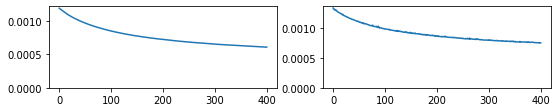

In [ ]:
epochs_counter=400
batch_size=64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

In [ ]:
#TO SAVE THE MODEL
tosave_data = {'model': model,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),}
# Write a pickle file using pytorch 
th.save(tosave_data, "modelcv2d_model1_500epochs")

In [ ]:
checkpoint = th.load("modelcv2d_model1_500epochs")
# restore the model and optimizer states: 
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
#steps_to_predict=checkpoint['steps_to_predict']
#size_conv_time=checkpoint['size_conv_time']

<All keys matched successfully>

In [17]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=40200
steps_to_predict = 15
size_conv_time = 10
N_step_pred=20
print('Start_position=', start_position)
x, y = prediction2D(model,start_position,N_step_pred,size_conv_time,steps_to_predict,state_history_norm_th)

Start_position= 40200


RuntimeError: ignored

## Model 2

In [ ]:
#CONV1
in_channel_1 = 1
Hin_ch_conv_1 = sample_points
Win_ch_conv_1 = size_conv_time

kH_conv_1 = 6
stH_conv_1 = 1
padH_conv_1 = 0

kW_conv_1 = 5
stW_conv_1 = 1
padW_conv_1 = 2

Hout_ch_conv_1 = (Hin_ch_conv_1+2*padH_conv_1-(kH_conv_1-1)-1)/stH_conv_1+1
Wout_ch_conv_1 = (Win_ch_conv_1+2*padW_conv_1-(kW_conv_1-1)-1)/stW_conv_1+1
out_channel_1 = 3


#MAXPOOL1
kH_pool_1= 3
stH_pool_1= 1

kW_pool_1= 3
stW_pool_1= 1

Hin_ch_conv_2 = (Hout_ch_conv_1 - kH_pool_1)/stH_pool_1 + 1
Win_ch_conv_2 = (Wout_ch_conv_1 - kW_pool_1)/stW_pool_1 + 1


#CONV2
in_channel_2 = out_channel_1

kH_conv_2 = 9
stH_conv_2 = 2
padH_conv_2 = 2

kW_conv_2 = 7
stW_conv_2 = 1
padW_conv_2 = 1

Hout_ch_conv_2 = (Hin_ch_conv_2+2*padH_conv_2-(kH_conv_2-1)-1)/stH_conv_2+1
Wout_ch_conv_2 = (Win_ch_conv_2+2*padW_conv_2-(kW_conv_2-1)-1)/stW_conv_2+1
out_channel_2 = 1


#MAXPOOL2

kH_pool_2= 3
stH_pool_2= 1

kW_pool_2= 3
stW_pool_2= 1

Hin_ch_conv_3 = (Hout_ch_conv_2 - kH_pool_2)/stH_pool_2 + 1
Win_ch_conv_3 = (Wout_ch_conv_2 - kW_pool_2)/stW_pool_2 + 1

in_lin = int(Hin_ch_conv_3)
out_lin = sample_points

print(Hout_ch_conv_1)
print(Wout_ch_conv_1)

print(Hin_ch_conv_2)
print(Win_ch_conv_2)

print(Hout_ch_conv_2)
print(Wout_ch_conv_2)

print(Hin_ch_conv_3)
print(Win_ch_conv_3) 

in_lin = int(Hin_ch_conv_3*Win_ch_conv_3)
out_lin = sample_points*steps_to_predict
hidden_lin = sample_points*9

model = th.nn.Sequential(
    th.nn.Conv2d(in_channel_1,out_channel_1,kernel_size=(kH_conv_1,kW_conv_1),stride=(stH_conv_1,stW_conv_1),padding=(padH_conv_1,padW_conv_1)),
    th.nn.LeakyReLU(),
    th.nn.MaxPool2d(kernel_size=(kH_pool_1,kW_pool_1),stride=(stH_pool_1,stW_pool_1)),
    th.nn.Conv2d(in_channel_2,out_channel_2,kernel_size=(kH_conv_2,kW_conv_2),stride=(stH_conv_2,stW_conv_2),padding=(padH_conv_2,padW_conv_2)),
    th.nn.LeakyReLU(),
    th.nn.MaxPool2d(kernel_size=(kH_pool_2,kW_pool_2),stride=(stH_pool_2,stW_pool_2)),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_lin),
    th.nn.Tanh(),
    th.nn.Linear(hidden_lin,out_lin),
    th.nn.Tanh(),
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

59.0
25.0
57.0
23.0
27.0
19.0
25.0
17.0


Epoch	Train Loss	Valid Loss
0	 0.14194..	 0.14276..
1	 0.04274..	 0.01816..
2	 0.01157..	 0.00818..
3	 0.00611..	 0.00519..
4	 0.00420..	 0.00385..
5	 0.00323..	 0.00308..
6	 0.00263..	 0.00257..
7	 0.00222..	 0.00222..
8	 0.00193..	 0.00196..
9	 0.00172..	 0.00177..
10	 0.00156..	 0.00163..
11	 0.00143..	 0.00149..
12	 0.00132..	 0.00142..
13	 0.00124..	 0.00132..
14	 0.00116..	 0.00127..
15	 0.00110..	 0.00119..
16	 0.00105..	 0.00114..
17	 0.00100..	 0.00110..
18	 0.00096..	 0.00105..
19	 0.00092..	 0.00101..
20	 0.00089..	 0.00099..
21	 0.00086..	 0.00098..
22	 0.00083..	 0.00094..
23	 0.00081..	 0.00091..
24	 0.00079..	 0.00089..
25	 0.00077..	 0.00087..
26	 0.00075..	 0.00085..
27	 0.00073..	 0.00084..
28	 0.00071..	 0.00082..
29	 0.00070..	 0.00082..
30	 0.00069..	 0.00079..
31	 0.00067..	 0.00078..
32	 0.00066..	 0.00077..
33	 0.00065..	 0.00076..
34	 0.00064..	 0.00074..
35	 0.00063..	 0.00074..
36	 0.00062..	 0.00073..
37	 0.00061..	 0.00074..
38	 0.00060..	 0.00071..
39	 0.0

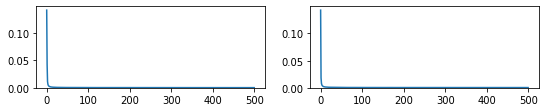

In [ ]:
epochs_counter=500
batch_size=64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

In [ ]:
#TO SAVE THE MODEL
tosave_data = {'model': model,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),}
# Write a pickle file using pytorch 
th.save(tosave_data, "modelcv2d_model2_500epochs")

NameError: ignored

In [ ]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=200
N_step_pred=1000
print('Start_position=', start_position)
prediction(model,start_position,N_step_pred,state_history_norm_th)

In [ ]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=3000
N_step_pred=1000
print('Start_position=', start_position)
prediction(model,start_position,N_step_pred,state_history_norm_th)

## Model 3

In [ ]:
#CONV1
in_channel_1 = 1
Hin_ch_conv_1 = sample_points
Win_ch_conv_1 = 100

kH_conv_1 = 4
stH_conv_1 = 1
padH_conv_1 = 2

kW_conv_1 = 4
stW_conv_1 = 3
padW_conv_1 = 3

Hout_ch_conv_1 = (Hin_ch_conv_1+2*padH_conv_1-(kH_conv_1-1)-1)/stH_conv_1+1
Wout_ch_conv_1 = (Win_ch_conv_1+2*padW_conv_1-(kW_conv_1-1)-1)/stW_conv_1+1
out_channel_1 = 3


#MAXPOOL1
kH_pool_1= 3
stH_pool_1= 1

kW_pool_1= 3
stW_pool_1= 2

Hin_ch_conv_2 = (Hout_ch_conv_1 - kH_pool_1)/stH_pool_1 + 1
Win_ch_conv_2 = (Wout_ch_conv_1 - kW_pool_1)/stW_pool_1 + 1




#CONV2
in_channel_2 = out_channel_1

kH_conv_2 = 4
stH_conv_2 = 1
padH_conv_2 = 1

kW_conv_2 = 5
stW_conv_2 = 4
padW_conv_2 = 0

Hout_ch_conv_2 = (Hin_ch_conv_2+2*padH_conv_2-(kH_conv_2-1)-1)/stH_conv_2+1
Wout_ch_conv_2 = (Win_ch_conv_2+2*padW_conv_2-(kW_conv_2-1)-1)/stW_conv_2+1
out_channel_2 = 1


#MAXPOOL2

kH_pool_2= 4
stH_pool_2= 1

kW_pool_2= 4
stW_pool_2= 1

Hin_ch_conv_3 = (Hout_ch_conv_2 - kH_pool_2)/stH_pool_2 + 1
Win_ch_conv_3 = (Wout_ch_conv_2 - kW_pool_2)/stW_pool_2 + 1


#Linear

in_lin = int(Hin_ch_conv_3)
hidden_lin1 = sample_points
hidden_lout1 = sample_points*2
out_lin = sample_points

model = th.nn.Sequential(
    th.nn.Conv2d(in_channel_1,out_channel_1,kernel_size=(kH_conv_1,kW_conv_1),stride=(stH_conv_1,stW_conv_1),padding=(padH_conv_1,padW_conv_1)),
    th.nn.LeakyReLU(),
    th.nn.MaxPool2d(kernel_size=(kH_pool_1,kW_pool_1),stride=(stH_pool_1,stW_pool_1)),
    th.nn.Conv2d(in_channel_2,out_channel_2,kernel_size=(kH_conv_2,kW_conv_2),stride=(stH_conv_2,stW_conv_2),padding=(padH_conv_2,padW_conv_2)),
    th.nn.LeakyReLU(),
    th.nn.MaxPool2d(kernel_size=(kH_pool_2,kW_pool_2),stride=(stH_pool_2,stW_pool_2)),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_lin1),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_lin1,hidden_lout1),
    th.nn.Tanh(),
    th.nn.Linear(hidden_lout1,out_lin),
    th.nn.Tanh(),
)
                   

model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

In [ ]:
epochs_counter=500
batch_size=64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

NameError: ignored

In [ ]:
model

In [14]:
size_conv_time=100
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=40012
N_step_pred=1000
print('Start_position=', start_position)
prediction(model,start_position,N_step_pred,state_history_norm_th)

Start_position= 40012


NameError: ignored

In [ ]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=3000
N_step_pred=1000
print('Start_position=', start_position)
prediction(model,start_position,N_step_pred,state_history_norm_th)

In [ ]:
state_history.shape

In [ ]:
#TO SAVE THE MODEL

tosave_data = {'model': model,
               'epoch': epoch,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
# Write a pickle file using pytorch 
th.save(tosave_data, "modelcv2d_model3_u3")

In [ ]:
cd ../ks-simulator/Models/

In [ ]:
name = "modelcv2d_model3_u3"
checkpoint = th.load(name)
# restore the model and optimizer states: 
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']
loss_fn=checkpoint['loss']
train_losses=checkpoint['training loss']
valid_losses=checkpoint['valid loss']

### the best model

In [12]:
#CONV1
in_channel_1 = 1
Hin_ch_conv_1 = sample_points
Win_ch_conv_1 = size_conv_time

kH_conv_1 = 5
stH_conv_1 = 1
padH_conv_1 = 2

kW_conv_1 = 5
stW_conv_1 = 1
padW_conv_1 = 2

Hout_ch_conv_1 = (Hin_ch_conv_1+2*padH_conv_1-(kH_conv_1-1)-1)/stH_conv_1+1
Wout_ch_conv_1 = (Win_ch_conv_1+2*padW_conv_1-(kW_conv_1-1)-1)/stW_conv_1+1
out_channel_1 = 5


#MAXPOOL1
kH_pool_1= 3
stH_pool_1= 1

kW_pool_1= 3
stW_pool_1= 1

Hin_ch_conv_2 = (Hout_ch_conv_1 - kH_pool_1)/stH_pool_1 + 1
Win_ch_conv_2 = (Wout_ch_conv_1 - kW_pool_1)/stW_pool_1 + 1


#CONV2
in_channel_2 = out_channel_1

kH_conv_2 = 5
stH_conv_2 = 1
padH_conv_2 = 2

kW_conv_2 = 5
stW_conv_2 = 1
padW_conv_2 = 2

Hout_ch_conv_2 = (Hin_ch_conv_2+2*padH_conv_2-(kH_conv_2-1)-1)/stH_conv_2+1
Wout_ch_conv_2 = (Win_ch_conv_2+2*padW_conv_2-(kW_conv_2-1)-1)/stW_conv_2+1
out_channel_2 = 10


#MAXPOOL2

kH_pool_2= 3
stH_pool_2= 1

kW_pool_2= 3
stW_pool_2= 1

Hin_ch_conv_3 = (Hout_ch_conv_2 - kH_pool_2)/stH_pool_2 + 1
Win_ch_conv_3 = (Wout_ch_conv_2 - kW_pool_2)/stW_pool_2 + 1

#CONV3
in_channel_3 = out_channel_2

kH_conv_3 = 5
stH_conv_3 = 1
padH_conv_3 = 2

kW_conv_3 = 5
stW_conv_3 = 1
padW_conv_3 = 2

Hout_ch_conv_3 = (Hin_ch_conv_3+2*padH_conv_3-(kH_conv_3-1)-1)/stH_conv_3+1
Wout_ch_conv_3 = (Win_ch_conv_3+2*padW_conv_3-(kW_conv_3-1)-1)/stW_conv_3+1
out_channel_3 = 10


#MAXPOOL3

kH_pool_3 = 3
stH_pool_3 = 1

kW_pool_3 = 3
stW_pool_3 = 1

Hin_ch_conv_4 = (Hout_ch_conv_3 - kH_pool_3)/stH_pool_3 + 1
Win_ch_conv_4 = (Wout_ch_conv_3 - kW_pool_3)/stW_pool_3 + 1

#CONV4
in_channel_4 = out_channel_3

kH_conv_4 = 5
stH_conv_4 = 1
padH_conv_4 = 2

kW_conv_4 = 5
stW_conv_4 = 1
padW_conv_4 = 2

Hout_ch_conv_4 = (Hin_ch_conv_4+2*padH_conv_4-(kH_conv_4-1)-1)/stH_conv_4+1
Wout_ch_conv_4 = (Win_ch_conv_4+2*padW_conv_4-(kW_conv_4-1)-1)/stW_conv_4+1
out_channel_4 = 5

#MAXPOOL4

kH_pool_4 = 3
stH_pool_4 = 1

kW_pool_4 = 3
stW_pool_4 = 1

Hin_ch_conv_5 = (Hout_ch_conv_4 - kH_pool_4)/stH_pool_4 + 1
Win_ch_conv_5 = (Wout_ch_conv_4 - kW_pool_4)/stW_pool_4 + 1

#CONV5
in_channel_5 = out_channel_4

kH_conv_5 = 5
stH_conv_5 = 1
padH_conv_5 = 2

kW_conv_5 = 5
stW_conv_5 = 1
padW_conv_5 = 2

Hout_ch_conv_5 = (Hin_ch_conv_5+2*padH_conv_5-(kH_conv_5-1)-1)/stH_conv_5+1
Wout_ch_conv_5 = (Win_ch_conv_5+2*padW_conv_5-(kW_conv_5-1)-1)/stW_conv_5+1
out_channel_5 = 1


#MAXPOOL5

kH_pool_5 = 1
stH_pool_5 = 1

kW_pool_5 = 1
stW_pool_5 = 1

Hin_ch_conv_6 = (Hout_ch_conv_5 - kH_pool_5)/stH_pool_5 + 1
Win_ch_conv_6 = (Wout_ch_conv_5 - kW_pool_5)/stW_pool_5 + 1

print(Hout_ch_conv_1)
print(Wout_ch_conv_1)

print(Hin_ch_conv_2)
print(Win_ch_conv_2)

print(Hin_ch_conv_3)
print(Win_ch_conv_3) 

print(Hin_ch_conv_4)
print(Win_ch_conv_4) 


print(Hin_ch_conv_5)
print(Win_ch_conv_5) 


print(Hin_ch_conv_6)
print(Win_ch_conv_6) 

in_lin = int(Hin_ch_conv_6*Win_ch_conv_6)
out_lin = sample_points*steps_to_predict
hidden_lin1 = sample_points*5
hidden_lin2 = sample_points*7
hidden_lin3 = sample_points*9
hidden_lin4 = sample_points*11
hidden_lin5 = sample_points*15
hidden_lin6 = sample_points*17
hidden_lin7 = sample_points*19
hidden_lin8 = sample_points*17

model = th.nn.Sequential(
    th.nn.Conv2d(in_channel_1,out_channel_1,kernel_size=(kH_conv_1,kW_conv_1),stride=(stH_conv_1,stW_conv_1),padding=(padH_conv_1,padW_conv_1)),
    th.nn.LeakyReLU(),
    th.nn.MaxPool2d(kernel_size=(kH_pool_1,kW_pool_1),stride=(stH_pool_1,stW_pool_1)),
    th.nn.Conv2d(in_channel_2,out_channel_2,kernel_size=(kH_conv_2,kW_conv_2),stride=(stH_conv_2,stW_conv_2),padding=(padH_conv_2,padW_conv_2)),
    th.nn.LeakyReLU(),
    th.nn.MaxPool2d(kernel_size=(kH_pool_2,kW_pool_2),stride=(stH_pool_2,stW_pool_2)),
    th.nn.Conv2d(in_channel_3,out_channel_3,kernel_size=(kH_conv_3,kW_conv_3),stride=(stH_conv_3,stW_conv_3),padding=(padH_conv_3,padW_conv_3)),
    th.nn.LeakyReLU(),
    th.nn.MaxPool2d(kernel_size=(kH_pool_3,kW_pool_3),stride=(stH_pool_3,stW_pool_3)),
    th.nn.Conv2d(in_channel_4,out_channel_4,kernel_size=(kH_conv_4,kW_conv_4),stride=(stH_conv_4,stW_conv_4),padding=(padH_conv_4,padW_conv_4)),
    th.nn.LeakyReLU(),
    th.nn.MaxPool2d(kernel_size=(kH_pool_4,kW_pool_4),stride=(stH_pool_4,stW_pool_4)),
    th.nn.Conv2d(in_channel_5,out_channel_5,kernel_size=(kH_conv_5,kW_conv_5),stride=(stH_conv_5,stW_conv_5),padding=(padH_conv_5,padW_conv_5)),
    th.nn.LeakyReLU(),
    th.nn.MaxPool2d(kernel_size=(kH_pool_5,kW_pool_5),stride=(stH_pool_5,stW_pool_5)),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_lin1),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_lin1,hidden_lin2),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_lin2,hidden_lin3),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_lin3,hidden_lin4),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_lin4,hidden_lin5),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_lin5,hidden_lin6),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_lin6,hidden_lin7),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_lin7,hidden_lin8),
    th.nn.LeakyReLU(),    
    th.nn.Linear(hidden_lin8,out_lin),
    th.nn.Tanh(),
)
                   

model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

64.0
10.0
62.0
8.0
60.0
6.0
58.0
4.0
56.0
2.0
56.0
2.0


In [13]:
name = "modelcv2d_model5_10_50epochs"

checkpoint = th.load(name)
# restore the model and optimizer states: 
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
#steps_to_predict=checkpoint['steps_to_predict']
#size_conv_time=checkpoint['size_conv_time']

<All keys matched successfully>

In [20]:
epochs_counter=150
batch_size=64
train2(model,X_train_th,Y_train_th,epochs=epochs_counter,batch_size=batch_size)
#TO SAVE THE MODEL
tosave_data = {'model': model,
               'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,}
# Write a pickle file using pytorch
th.save(tosave_data, "modelcv2d_model5_10_200epochs")

Epoch	Train Loss	Valid Loss
0	 0.00036..	
1	 0.00036..	
2	 0.00036..	
3	 0.00036..	
4	 0.00036..	
5	 0.00036..	
6	 0.00036..	
7	 0.00036..	
8	 0.00036..	
9	 0.00036..	
10	 0.00036..	
11	 0.00036..	
12	 0.00036..	
13	 0.00036..	
14	 0.00036..	
15	 0.00036..	
16	 0.00036..	
17	 0.00036..	
18	 0.00036..	
19	 0.00036..	
20	 0.00036..	
21	 0.00036..	
22	 0.00036..	
23	 0.00036..	
24	 0.00036..	
25	 0.00036..	
26	 0.00036..	
27	 0.00036..	
28	 0.00036..	
29	 0.00036..	
30	 0.00036..	
31	 0.00036..	
32	 0.00036..	
33	 0.00036..	
34	 0.00036..	
35	 0.00036..	
36	 0.00036..	
37	 0.00036..	
38	 0.00036..	
39	 0.00036..	
40	 0.00036..	
41	 0.00036..	
42	 0.00036..	
43	 0.00036..	
44	 0.00036..	
45	 0.00036..	
46	 0.00036..	
47	 0.00036..	
48	 0.00036..	
49	 0.00036..	
50	 0.00036..	
51	 0.00036..	
52	 0.00036..	
53	 0.00036..	
54	 0.00036..	
55	 0.00036..	
56	 0.00036..	
57	 0.00036..	
58	 0.00036..	
59	 0.00036..	
60	 0.00036..	
61	 0.00036..	
62	 0.00036..	
63	 0.00036..	
64	 0.00036..	
65	 0.0

KeyboardInterrupt: ignored